<a href="https://colab.research.google.com/github/yegisafari/Breast-Cancer-Detection---calcifications-vs.-masses/blob/main/breast_cancer_detection_train_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import ast
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm

from skimage.io import imsave
from skimage.transform import resize

In [ ]:
data_dir =  '/content/drive/MyDrive/VinDr/files/vindr-mammo/1.0.0/'
data = pd.read_csv(os.path.join(data_dir,'breast-level_annotations.csv'))
meta = pd.read_csv(os.path.join(data_dir,'metadata.csv'))
meta = meta.rename(columns={'SOP Instance UID': 'image_id'})
data = data.merge(meta, on='image_id')

In [ ]:
image_size = (512,512)


In [ ]:
image_folder = os.path.join(data_dir,'images')
data2 = data[data['study_id'].apply(lambda x : x in os.listdir(image_folder) )]

In [ ]:
data2 = data2.reset_index()

In [ ]:
data2['split'] = 'training'

In [ ]:
data2['split'].iloc[2*len(data2)//3:] = 'test'

<ipython-input-11-194dff421624>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['split'].iloc[2*len(data2)//3:] = 'test'


In [ ]:
data2['split'].value_counts()

split
training    109
test         55
Name: count, dtype: int64

# Train

In [ ]:
!pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.3/812.3 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 17.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-many

In [ ]:
!pip install torchsampler

In [ ]:
image_names = []
image_folder_dir = '/content/drive/MyDrive/VinDr/files/vindr-mammo/1.0.0/images_512x512'
for folder in os.listdir(image_folder_dir):
  folder_path = os.path.join(image_folder_dir,folder)
  for image in os.listdir(folder_path):
    image_names.append(image)


In [ ]:
data_dir ='/content/drive/MyDrive/VinDr/files/vindr-mammo/1.0.0/'
# df = pd.read_csv(os.path.join(data_dir,'breast-level_annotations.csv'))
data2 = data2[data2['image_id'].apply(lambda x : x in list(map(lambda x : x.replace('.png',''), image_names)))]
data2.to_csv(os.path.join(data_dir,'breast-level_annotations2.csv'))

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from argparse import ArgumentParser
from sklearn.utils import shuffle
from skimage.io import imread

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as T
from torchvision import models

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

from torchsampler import ImbalancedDatasetSampler
from torchmetrics.functional import auroc

data_dir = '/content/drive/MyDrive/VinDr/files/vindr-mammo/1.0.0/'

image_size = (512, 512)     # image input size (depends on data pre-processing)
val_percent = 0.1           # how much of total training samples are used for model selection (default 10%)
batch_size = 20            # batch size may need to be adjusted depending on GPU memory
epochs = 8                 # number of training epochs
num_workers = 4             # number threads for data processing


class MammoDataset(Dataset):
    def __init__(self, data, data_dir, image_size, augmentation=False):
        self.data = data.reset_index(drop=True)
        self.data_dir = data_dir
        self.image_size = image_size
        self.do_augment = augmentation

        # photometric data augmentation
        self.photometric_augment = T.Compose([
            T.RandomApply(transforms=[T.ColorJitter(brightness=0.2, contrast=0.2)], p=0.5),
        ])

        # geometric data augmentation
        self.geometric_augment = T.Compose([
            T.RandomApply(transforms=[T.RandomAffine(degrees=10, scale=(0.9, 1.1))], p=0.5),
        ])

        self.samples = []
        for idx, _ in enumerate(tqdm(range(len(self.data)), desc='Loading Data')):
            img_path = os.path.join(self.data_dir, 'images_512x512', self.data.loc[idx, 'study_id'], self.data.loc[idx, 'image_id'] + '.png')
            img_label = np.array(self.data.loc[idx, 'malignancy_label'], dtype='int64')

            sample = {'image_path': img_path, 'label': img_label, 'study_id': self.data.loc[idx, 'study_id'], 'image_id': self.data.loc[idx, 'image_id']}
            self.samples.append(sample)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        sample = self.get_sample(item)

        image = torch.from_numpy(sample['image']).unsqueeze(0)
        label = torch.from_numpy(sample['label'])

        image = image.repeat(3, 1, 1)

        if self.do_augment:
            image = self.photometric_augment(image.type(torch.ByteTensor)).type(torch.FloatTensor)
            image = self.geometric_augment(image)

        return {'image': image, 'label': label, 'study_id': sample['study_id'], 'image_id': sample['image_id']}

    def get_sample(self, item):
        sample = self.samples[item]
        image = imread(sample['image_path']).astype(np.float32)

        return {'image': image, 'label': sample['label'], 'study_id': sample['study_id'], 'image_id': sample['image_id']}

    def get_labels(self):
        labels = [int(sample['label']) for sample in self.samples]
        return labels


class MammoDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, image_size, val_percent, batch_size, num_workers):
        super().__init__()
        self.data_dir = data_dir
        self.image_size = image_size
        self.val_percent = val_percent
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.data = pd.read_csv(os.path.join(self.data_dir,'breast-level_annotations2.csv'))
        self.data['malignancy_label'] = self.data['breast_birads']

        # Define positive and negatives based on BI-RADS categories
        self.data.loc[self.data['malignancy_label'] == 'BI-RADS 1', 'malignancy_label'] = 0
        self.data.loc[self.data['malignancy_label'] == 'BI-RADS 2', 'malignancy_label'] = 0
        self.data.loc[self.data['malignancy_label'] == 'BI-RADS 3', 'malignancy_label'] = 0
        self.data.loc[self.data['malignancy_label'] == 'BI-RADS 4', 'malignancy_label'] = 0
        self.data.loc[self.data['malignancy_label'] == 'BI-RADS 5', 'malignancy_label'] = 1

        # Use pre-defined splits to separate data into development and testing
        self.dev_data = self.data[self.data['split'] == 'training']
        self.test_data = self.data[self.data['split'] == 'test']

        # Split development data into training and validation (for model selection)
        # Making sure images from the same subject are within the same set
        unique_study_ids = self.dev_data.study_id.unique()

        unique_study_ids = shuffle(unique_study_ids)
        num_train = (round(len(unique_study_ids)*(1.0 - self.val_percent)))

        valid_sub_id = unique_study_ids[num_train:]
        self.dev_data.loc[self.dev_data.study_id.isin(valid_sub_id), "split"]="validation"

        self.train_data = self.dev_data[self.dev_data['split'] == 'training']
        self.val_data = self.dev_data[self.dev_data['split'] == 'validation']

        self.train_set = MammoDataset(self.train_data, data_dir, self.image_size, augmentation=True)
        self.val_set = MammoDataset(self.val_data, data_dir, self.image_size, augmentation=False)
        self.test_set = MammoDataset(self.test_data, data_dir, self.image_size, augmentation=False)

        train_labels = self.train_set.get_labels()
        train_class_count = np.array([len(np.where(train_labels == t)[0]) for t in np.unique(train_labels)])

        val_labels = self.val_set.get_labels()
        val_class_count = np.array([len(np.where(val_labels == t)[0]) for t in np.unique(val_labels)])

        test_labels = self.test_set.get_labels()
        test_class_count = np.array([len(np.where(test_labels == t)[0]) for t in np.unique(test_labels)])

        # print('samples (train): ',len(self.train_set))
        # # print('samples (val):   ',len(self.val_set))
        # print('samples (test):  ',len(self.test_set))
        # print('pos/neg (train): {}/{}'.format(train_class_count[1], train_class_count[0]))
        # # print('pos/neg (val):   {}/{}'.format(val_class_count[1], val_class_count[0]))
        # print('pos/neg (test):  {}/{}'.format(test_class_count[1], test_class_count[0]))
        # print('pos (train):     {:0.2f}%'.format(train_class_count[1]/len(train_labels)*100.0))
        # # print('pos (val):       {:0.2f}%'.format(val_class_count[1]/len(val_labels)*100.0))
        # print('pos (test):      {:0.2f}%'.format(test_class_count[1]/len(test_labels)*100.0))

    def train_dataloader(self):
        return DataLoader(dataset=self.train_set, batch_size=self.batch_size, sampler=ImbalancedDatasetSampler(self.train_set), num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(dataset=self.val_set, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(dataset=self.test_set, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)


class MammoNet(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.num_classes = 2
        self.predictions = []
        self.targets = []
        self.study_ids = []
        self.image_ids = []

        self.train_step_preds = []
        self.train_step_trgts = []
        self.val_step_preds = []
        self.val_step_trgts = []

        # Default model is an ImageNet pre-trained ResNet-18
        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        # self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, self.num_classes)

    def forward(self, x):
        return self.model.forward(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def process_batch(self, batch):
        img, lab = batch['image'], batch['label']
        out = self.forward(img)
        prd = torch.softmax(out, dim=1)
        loss = F.cross_entropy(out, lab)
        return loss, prd, lab

    def training_step(self, batch, batch_idx):
        loss, prd, lab = self.process_batch(batch)
        self.train_step_preds.append(prd)
        self.train_step_trgts.append(lab)
        self.log('train_loss', loss, batch_size=batch_size)
        batch_ratio = len(np.where(lab.cpu().numpy() == 1)[0]) / len(np.where(lab.cpu().numpy() == 0)[0])
        self.log('batch_ratio', batch_ratio, batch_size=batch_size)
        grid = torchvision.utils.make_grid(batch['image'][0:4, ...], nrow=2, normalize=True)
        self.logger.experiment.add_image('images', grid, self.global_step)
        return loss

    def on_train_epoch_end(self):
        all_preds = torch.cat(self.train_step_preds, dim=0)
        all_trgts = torch.cat(self.train_step_trgts, dim=0)
        auc = auroc(all_preds, all_trgts, num_classes=self.num_classes, average='macro', task='multiclass')
        self.log('train_auc', auc, batch_size=len(all_preds))
        self.train_step_preds.clear()
        self.train_step_trgts.clear()

    def validation_step(self, batch, batch_idx):
        loss, prd, lab = self.process_batch(batch)
        self.val_step_preds.append(prd)
        self.val_step_trgts.append(lab)
        self.log('val_loss', loss, batch_size=batch_size)

    def on_validation_epoch_end(self):
        all_preds = torch.cat(self.val_step_preds, dim=0)
        all_trgts = torch.cat(self.val_step_trgts, dim=0)
        auc = auroc(all_preds, all_trgts, num_classes=self.num_classes, average='macro', task='multiclass')
        self.log('val_auc', auc, batch_size=len(all_preds))
        self.val_step_preds.clear()
        self.val_step_trgts.clear()

    def on_test_start(self):
        self.predictions = []
        self.targets = []
        self.study_ids = []
        self.image_ids = []

    def test_step(self, batch, batch_idx):
        _, prd, lab = self.process_batch(batch)
        self.predictions.append(prd)
        self.targets.append(lab.squeeze())
        self.study_ids.append(batch['study_id'])
        self.image_ids.append(batch['image_id'])


def save_predictions(model, output_fname):
    prds = torch.cat(model.predictions, dim=0)
    trgs = torch.cat(model.targets, dim=0)
    std_ids = [id for sublist in model.study_ids for id in sublist]
    img_ids = [id for sublist in model.image_ids for id in sublist]

    auc = auroc(prds, trgs, num_classes=2, average='macro', task='multiclass')

    print('AUROC (test)')
    print(auc)

    cols_names = ['class_' + str(i) for i in range(0, 2)]

    df = pd.DataFrame(data=prds.cpu().numpy(), columns=cols_names)
    df['target'] = trgs.cpu().numpy()
    df['study_id'] = std_ids
    df['image_id'] = img_ids
    df.to_csv(output_fname, index=False)


def main():

    # sets seeds for numpy, torch, python.random and PYTHONHASHSEED.
    pl.seed_everything(42, workers=True)

    # data
    data = MammoDataModule(data_dir=data_dir,
                              image_size=image_size,
                              val_percent=val_percent,
                              batch_size=batch_size,
                              num_workers=num_workers)

    # model
    model = MammoNet()

    # Create output directory
    output_base_dir = 'output'
    output_name = 'resnet18'
    output_dir = os.path.join(output_base_dir,output_name)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    print('=============================================================')
    print('Training...')

    # train
    checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode='min')
    trainer = pl.Trainer(
        callbacks=[checkpoint_callback],
        log_every_n_steps=5,
        max_epochs=epochs,
        accelerator='gpu',
        devices=1,
        logger=TensorBoardLogger(output_base_dir, name=output_name),
    )
    trainer.logger._default_hp_metric = False
    trainer.fit(model, data)

    model = MammoNet.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    print('=============================================================')
    print('Testing...')

    trainer.test(model=model, datamodule=data)
    save_predictions(model=model, output_fname=os.path.join(output_dir, 'predictions.csv'))




In [ ]:



main()

INFO:lightning_fabric.utilities.seed:Seed set to 42
Loading Data: 100%|██████████| 55/55 [00:00<00:00, 8304.66it/s]
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 130MB/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True


Training...


INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | model | ResNet | 11.2 M | train
-----------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-pac

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=8` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing...


Testing: |          | 0/? [00:00<?, ?it/s]

AUROC (test)
tensor(0.4575, device='cuda:0')


# evaluation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [ ]:
result_dir = 'output/resnet18/'
data = pd.read_csv(result_dir + 'predictions.csv')

In [ ]:
data

,class_0,class_1,target,study_id,image_id
0,1.0,1.295609e-35,0,004426a40da27ef22a866538b772ac44,d3ae4a0aa59a608a2823c029e988985f
1,1.0,7.115782e-29,0,004426a40da27ef22a866538b772ac44,7197f7e6f5ca3b9821d0460dcdc975d3
2,1.0,5.992939e-35,0,004426a40da27ef22a866538b772ac44,265596e3534efced063b4e656b7bd64f
3,1.0,1.170565e-22,0,012d54f2fd7cd14b44cc76e32c322b37,02bfa44c5d38d04bdb6d6e22b647e6a8
4,1.0,4.561294e-27,0,012d54f2fd7cd14b44cc76e32c322b37,fcbed716342994da2c2926f1eda7df4c
5,1.0,9.953420e-23,0,012d54f2fd7cd14b44cc76e32c322b37,cc59b280b6e8df33c933cce3d0a460fb
6,1.0,1.976464e-29,0,012d54f2fd7cd14b44cc76e32c322b37,d36990548ec0ddd584e7795839208096
7,1.0,3.362377e-19,0,00d888649670af0a057b18fddbb42276,19cfe58427dd1f071ffa8573b7b8c4a8
8,1.0,1.027004e-23,0,00d888649670af0a057b18fddbb42276,56dc465df5ef88836f667c85bafef1fe
9,1.0,9.216315e-20,0,00d888649670af0a057b18fddbb42276,c302d7a071e926ff7c66dc9cc76d00c9


In [ ]:
preds = np.stack([data['class_0'],data['class_1']]).transpose()
targets = np.array(data['target'])
fpr, tpr, _ = roc_curve(targets, preds[:,1])
roc_auc = auc(fpr, tpr)

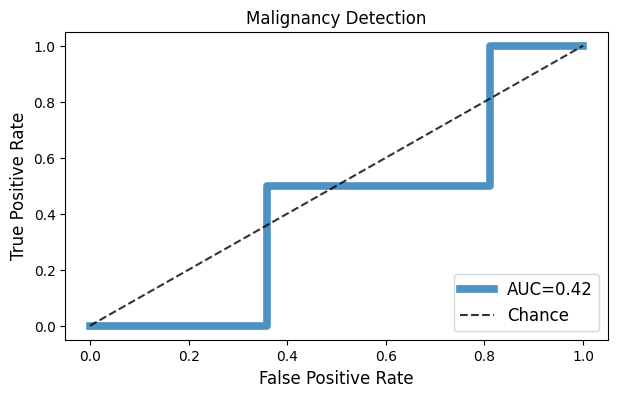

In [ ]:
fig, ax = plt.subplots(figsize=(7,4))
plt.plot(fpr, tpr, lw=5.5, alpha=.8, label='AUC=%0.2f' % roc_auc)
ax.plot([0, 1], [0, 1], linestyle='--', lw=1.5, color='k', label='Chance', alpha=.8)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc="lower right", fontsize=12)
plt.title('Malignancy Detection', fontsize=12)
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
plt.show()

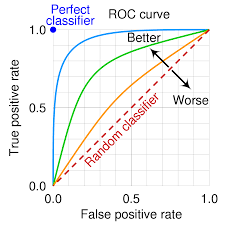